### Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Extract dataset

In [ ]:
! tar -zxvf drive/MyDrive/I2ML/dataset.tar.gz

In [ ]:
#%cd dataset
#%cd ..
! ls
# cd train


### Splitting folder for validation

In [ ]:
! mkdir dataset/src

In [ ]:
from distutils.dir_util import copy_tree
import shutil
copy_tree("dataset/train/", "dataset/src")

shutil.rmtree('dataset/train/')

In [ ]:
! ls dataset/src/Merging/

In [ ]:
import os
import numpy as np
import shutil
import random

# # Creating Train / Val folders (One time use)
root_dir = 'dataset'
classes_dir = ['/Barred Spiral','/Edge-on without Bulge','/Unbarred Loose Spiral','/Cigar Shaped Smooth','/In-between Round Smooth','/Unbarred Tight Spiral','/Disturbed','/Merging','/Edge-on with Bulge','/Round Smooth']

#val_ratio = 0.15
#test_ratio = 0.05
for cls in classes_dir:
    
    os.makedirs(root_dir +'/train' + cls)
    os.makedirs(root_dir +'/val' + cls)

    # Creating partitions of the data after shuffeling
    src = root_dir + "/src" + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    random.shuffle(allFileNames)
    print(len(allFileNames))
    
    
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)*0.8)])
                                              

    """
    train_FileNames, val_FileNames = torch.utils.data.random_split(allFileNames[i], 
                                                                  [int(len(allFileNames[i])*0.8), int(len(allFileNames[i])*0.2)], 
                                                                  generator=torch.Generator().manual_seed(42))
    """


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'/val' + cls)
    


In [ ]:
!ls dataset/val/Barred\ Spiral

In [ ]:
! mkdir dataset/test/unknown
! mv dataset/test/*.png dataset/test/unknown/

# Various imports

In [ ]:
import numpy as np # linear algebra
import os
import torch
import tarfile
import torchvision
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url


# Dataset, data loader, transformations

In [ ]:
transform_train = transforms.Compose([
    
    transforms.Resize((224,224)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor(),
    #transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    
])

#Augmentation is not done for test/validation data.
transform_test = transforms.Compose([
    
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    #transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    
])


In [ ]:
train_ds = ImageFolder('./dataset/train', transform=transform_train)
test_ds = ImageFolder('./dataset/val', transform=transform_test)
pred_ds = ImageFolder('./dataset/test', transform=transform_test)

In [ ]:
#checking lengths
len(train_ds),len(test_ds),len(pred_ds)

(9928, 2487, 5321)

In [ ]:
image,label  = train_ds[0]
print(image.shape, label)

torch.Size([3, 224, 224]) 0


In [ ]:
batch_size=32
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)
pred_dl = DataLoader(pred_ds, batch_size, num_workers=2, pin_memory=True)

# Visualization of a batch in train set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([32, 3, 224, 224])


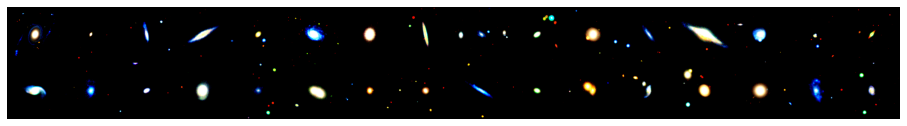

In [ ]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Utilities

In [ ]:
import pathlib
root = pathlib.Path('./dataset/train')
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes

['Barred Spiral',
 'Cigar Shaped Smooth',
 'Disturbed',
 'Edge-on with Bulge',
 'Edge-on without Bulge',
 'In-between Round Smooth',
 'Merging',
 'Round Smooth',
 'Unbarred Loose Spiral',
 'Unbarred Tight Spiral']

# Defintion of accuracy, training step, validation step

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        
        acc = accuracy(out, labels)
        return loss, acc
        
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f},  val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

In [ ]:
class CnnModelVGG(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = modelvgg19
        
    def forward(self, xb):
        return self.network(xb)

# Defining the functions for devices

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
pred_dl = DeviceDataLoader(pred_dl, device)
#to_device(model, device);

# Training phase

In [ ]:
categories = []
for d in os.listdir("dataset/train"):
    categories.append(d)
    
n_classes = len(categories)
print(f'There are {n_classes} different classes.')

categories = sorted(categories)

There are 10 different classes.


Defining the last layer of the network

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

Using the premade class for metrics

In [ ]:
class ClassificationMetrics:

  # Constructor takes the number of classes
  def __init__(self, num_classes=10):
    self.num_classes = num_classes
    # Initialize a confusion matrix
    self.C = torch.zeros(num_classes, num_classes) 

  # Update the confusion matrix with the new scores
  def add(self, yp, yt):
    # yp: 1D tensor with predictions
    # yt: 1D tensor with ground-truth targets
    with torch.no_grad(): # We require no computation graph
      self.C+=(yt*self.C.shape[1]+yp).bincount(minlength=self.C.numel()).view(self.C.shape).float()

  def clear(self):
    # We set the confusion matrix to zero
    self.C.zero_()

  # Computes the global accuracy
  def acc(self):
    return self.C.diag().sum().item()/self.C.sum()

  # Computes the class-averaged accuracy
  def mAcc(self):
    return (self.C.diag()/self.C.sum(-1)).mean().item()

  # Computers the class-averaged Intersection over Union
  def mIoU(self):
    return (self.C.diag()/(self.C.sum(0)+self.C.sum(1)-self.C.diag())).mean().item()

  # Returns the confusion matrix
  def confusion_matrix(self):
    return self.C

Retrieving of the best model and changing the last layer 

In [ ]:
bestModel = torch.load('/content/drive/MyDrive/Models/VGG/VGG19best.model')
bestModel.classifier = Identity()
bestModel.eval()
bestModel = to_device(bestModel, device)

Using SVM for training

In [ ]:
from sklearn import svm

features = []
targets=[]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
  for X,yt in train_dl:
    #X, yt = X.to(device), yt.to(device)

    ft_single = bestModel(X)

    ft_single = ft_single.cpu()
    yt = yt.cpu()

    features.append(ft_single)
    targets.append(yt)

features=torch.cat(features,dim=0)
targets=torch.cat(targets,dim=0)



svm_model=svm.SVC()
svm_model.fit(features,targets)

# We compute the performance of the trained svm on val data
metric_tracker=ClassificationMetrics(num_classes=10)
for X,yt in val_dl:
  with torch.no_grad():
    
    feat=bestModel(X)

    feat = feat.cpu()

    yp = svm_model.predict(feat)

    yt = yt.cpu()

    metric_tracker.add(yp,yt)

print("Acc: {} | mAcc: {} | mIoU: {}".format(metric_tracker.acc(),metric_tracker.mAcc(),metric_tracker.mIoU() ))


Acc: 0.8890228867530823 | mAcc: 0.8697832226753235 | mIoU: 0.7806361317634583


# Testing phase

Here we define the function that make the prediction on the single image

In [ ]:
def predict_single_testSVM(input, model, svm_model, path, pred_list):
    input = input.cuda()
    inputs = input.unsqueeze(0)   # unsqueeze the input i.e. add an additonal dimension
    
    feat = model(inputs)
    feat = feat.detach().cpu()

    pred = svm_model.predict(feat)
    pred = torch.from_numpy(pred)
    
    number_label = (pred).item()

    if number_label == 0:
      label = categories[0]
    if number_label == 1:
      label = categories[1]
    if number_label == 2:
      label = categories[2]
    if number_label == 3:
      label = categories[3]
    if number_label == 4:
      label = categories[4]
    if number_label == 5:
      label = categories[5]
    if number_label == 6:
      label = categories[6]
    if number_label == 7:
      label = categories[7]
    if number_label == 8:
      label = categories[8]
    if number_label == 9:
      label = categories[9]
    
    #print(path,",",label)
    pred_str = ""
    pred_str = pred_str + path + "," + label

    pred_dict = {}
    pred_dict['pred_str'] = pred_str
    pred_dict['num'] = int(path)
    
    #print(pred_dict)

    pred_list.append(pred_dict)
    

Here we predict the label of each image in test set and write in on a CSV file

In [ ]:
from torchvision import datasets
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        return super(ImageFolderWithPaths, self).__getitem__(index) + (self.imgs[index][0],)


# instantiate the dataset and dataloader
data_dir = "dataset/test"
dataset = ImageFolderWithPaths(root=data_dir, transform=transform_test)
dataloader = DataLoader(dataset)

pred_list = []

for inputs, labels, paths in dataloader:
   

    sliced = paths[0]
    sliced = sliced.replace('.png','')
    sliced = sliced.replace('dataset/test/unknown/','')
    
    
    

    predict_single_testSVM(inputs[0],bestModel, svm_model, sliced, pred_list)


    
pred_list = sorted(pred_list, key=lambda k: int(k['num'])) 

text_file = open("dataset/output.csv", "a")


for x in pred_list:
  #print (x['pred_str'])
  text_file.write(x['pred_str'])
  text_file.write("\n")

text_file.close()
